In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt


import random
SEED = 578924431 # For an unbalanced sub-set, set seed to 42. Properly balanced subset: 578924431

from sklearn.decomposition import PCA

# setting the colorscheme of the figures
COLOR = '#307890'
mpl.rcParams.update({'text.color' : COLOR,
                     'axes.labelcolor' : COLOR,
                     'xtick.color': COLOR,
                     'ytick.color': COLOR, 
                     'axes.edgecolor': COLOR})

# Creating a balanced subset of the combinational library

When optimising a genetically engineered machine, there are a lot of parts of this machine that could possibly be optimized. One strategy would be to optimize each part independantly and then put all "optimal" variants into a single machine. It is however highly unlikely that changing one part has no effect on the functioning of the other parts. In other words, the assumption of independence between each part required for the afore mentioned strategy does not hold. It is however infeasibale to test all possible combinations of the part-variants as the number of variants that would need to be tested increases exponentially with each added part. This raises the question: "How do I optimize my genetically engineered machine in a cost- and time-effective manner?". 

The Automated Recommendation Tool (ART) is designed exactly for this purpose by **ADD CITATION**. The tool uses machine learning to learn underlying dependencies between the varying parts of the genetically engineered machine based only on the results of a relatively small subset of the *combinatorial library* (a fancy word for a list with all possible combinations of the different part-variants). The exact working of the ART is discussed in the `performing_ART_analysis.ipynb` notebook. This notebook discusses how to create a subset of this combinatorial library in which each part-variant is sufficiently represented. 

## Step 1: Create the entire combinatorial library

Before it is possible to take a subset of the combinatorial library, the library needs to exist in the first place. This is done by creating a unique index for each part-variant and listing all posible combinations of these indeces.

For our analysis we used:
- 4 different *Saccharomyces spp.* strains
- 10 different promoters
- 4 different secretion signals
- 4 different alpha-amylase genes


In [2]:
# Listing the the number of variables and creating the associated indeces:
num_strains = 4
indeces_strains = np.array(range(1,num_strains+1)) # Results in an array with values [1,2,3,4]
num_promoters = 10
indeces_promoters = np.array(range(num_strains+1, num_strains+num_promoters+1)) # --> array with values [5,6,7,8,9,10,11,12,13,14]
num_secretion_signals = 4
indeces_secretion = np.array(range(num_strains+num_promoters+1, num_strains+num_promoters+num_secretion_signals+1)) # --> array with values [15,16,17,18]
num_genes = 4
indeces_genes = np.array(range(num_strains+num_promoters+num_secretion_signals+1, num_strains+num_promoters+num_secretion_signals+num_genes+1)) # --> array with values [19,20,21,22]


# determining the size of the combinatorial library
num_combinations = num_strains*num_genes*num_promoters*num_secretion_signals

print(f'Size combinatorial library: {num_combinations}')

Size combinatorial library: 640


In [3]:
print(indeces_strains)
print(indeces_promoters)
print(indeces_secretion)
print(indeces_genes)

[1 2 3 4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18]
[19 20 21 22]


After assigning an index to each part-variant, the entire library can be created by iteration over all variants of each part and putting those combinations into a single list.

In [4]:
def init_comb_library(size):
    
    # First, initialize 
    comb_library = [np.zeros(0) for i in range(size)]
    i = 0
    for idx1 in indeces_strains:
        for idx2 in indeces_promoters:
            for idx3 in indeces_secretion:
                for idx4 in indeces_genes:
                    comb_library[i] = [idx1, idx2, idx3, idx4]
                    i += 1
    return comb_library

Now that there is a function for creating the combinatorial library, it is possible to select a few entries from this library in order to create a subset.

In [5]:
# In order to be able to reproduce the created subset, always set the seed of the random number generator to a value 
# you know. This seed is used throughtout the notebook, so we initialized it in the very first cell.
np.random.seed(SEED) 

# We decided we wanted to explore about 10% of the entire combinatorial library. If you wish to explore an X amount, just fill in the that number.
percentage_comb_library = 10 
num_samples = int(np.rint(num_combinations*(percentage_comb_library/100)))

# Initializing the entire combinational library
comb_library = init_comb_library(num_combinations)

# Pick a number of random samples out of the combinatorial library
sample_indeces = np.random.choice(range(num_combinations), num_samples, replace=False)
samples = [comb_library[i] for i in sample_indeces]
samples = np.array(samples)
print(f'{num_samples}')

print(f'First five samples:')
print(samples[:5])

# transforming the samples into a dataframe and adding columns
samples = pd.DataFrame(samples, columns=['str_idx', 'pro_idx', 'sec_idx', 'gen_idx'])
names = ['#'+str(i).zfill(2) for i in range(1, num_samples+1)]
names_df = pd.DataFrame(names, columns=['Line Name'])
named_samples = samples.join(names_df)
# named_samples = named_samples.set_index('Line Name')

print(named_samples.head())

64
First five samples:
[[ 2  6 16 22]
 [ 4 11 18 19]
 [ 1  5 16 19]
 [ 1 11 18 19]
 [ 3  8 16 22]]
   str_idx  pro_idx  sec_idx  gen_idx Line Name
0        2        6       16       22       #01
1        4       11       18       19       #02
2        1        5       16       19       #03
3        1       11       18       19       #04
4        3        8       16       22       #05


## step 2: Creating the framework which can be used as input for the ART
At this step the basic framework which will be used as the input for the ART is designed. The steps that follow afterwards will show how to verify wether the subset created in the previous step is actualy a balanced subset. 

In [6]:

newdf = pd.DataFrame(np.repeat(named_samples.values,3,axis=0))
newdf.columns = named_samples.columns
newdf['Replicate'] = ['r0', 'r1', 'r2']*num_samples # creating entries for each replicate
newdf['Activity'] = '_' # creating an empty column for the actual measurement.
print(newdf)

# Setting the line name, replicate number and measurement value as first columns in the dataframe
# This is not a required step, but is more esthetically pleasing :)
cols = newdf.columns.tolist()
cols = cols[-3:] + cols[:-3]
sample_list = newdf[cols] 

print(sample_list)
sample_list.to_csv('Sample_list.csv', sep=',', index=False)

    str_idx pro_idx sec_idx gen_idx Line Name Replicate Activity
0         2       6      16      22       #01        r0        _
1         2       6      16      22       #01        r1        _
2         2       6      16      22       #01        r2        _
3         4      11      18      19       #02        r0        _
4         4      11      18      19       #02        r1        _
..      ...     ...     ...     ...       ...       ...      ...
187       1      12      16      21       #63        r1        _
188       1      12      16      21       #63        r2        _
189       4       6      18      19       #64        r0        _
190       4       6      18      19       #64        r1        _
191       4       6      18      19       #64        r2        _

[192 rows x 7 columns]
    Line Name Replicate Activity str_idx pro_idx sec_idx gen_idx
0         #01        r0        _       2       6      16      22
1         #01        r1        _       2       6      16      22
2

Now that there is a design for the input format, some mock-data can be generated which can be used for testing the ART pipeline before the actual measurements have been performed

In [7]:
# Creating mock data for the testing of the ART

np.random.seed(SEED)

mock_data = named_samples.copy()
mock_data['Activity'] = np.random.random(mock_data.shape[0])
print(mock_data)

mock_data.to_csv('mock_data.csv', sep=',', index=False)

    str_idx  pro_idx  sec_idx  gen_idx Line Name  Activity
0         2        6       16       22       #01  0.829131
1         4       11       18       19       #02  0.333064
2         1        5       16       19       #03  0.871142
3         1       11       18       19       #04  0.937158
4         3        8       16       22       #05  0.054991
..      ...      ...      ...      ...       ...       ...
59        4       14       15       22       #60  0.416399
60        4       14       17       20       #61  0.671471
61        4       13       16       20       #62  0.958380
62        1       12       16       21       #63  0.669798
63        4        6       18       19       #64  0.714480

[64 rows x 6 columns]


## (Optional) Step 3: Validating whether each part-variant is sufficiently represented within the subset

Generally speaking, a well balanced subset of a combinatorial library means that part-variant of a part is somewhat equally reprented in the subset. Verifying this can be done by creating a histrogram of the part-variant for each part. If it turns out that some part-variants are severely under represented, you can change the `SEED` parameter which was set in the first cell of this notebook and generate a different subset.


In [8]:
# Loading the official names of the part-variants
part_names = pd.read_csv('part_names.csv')
part_names = part_names.set_index('Index')

list(part_names.Name[indeces_strains])

['ySB76', 'ySB77', 'ySB78', 'ySB85']

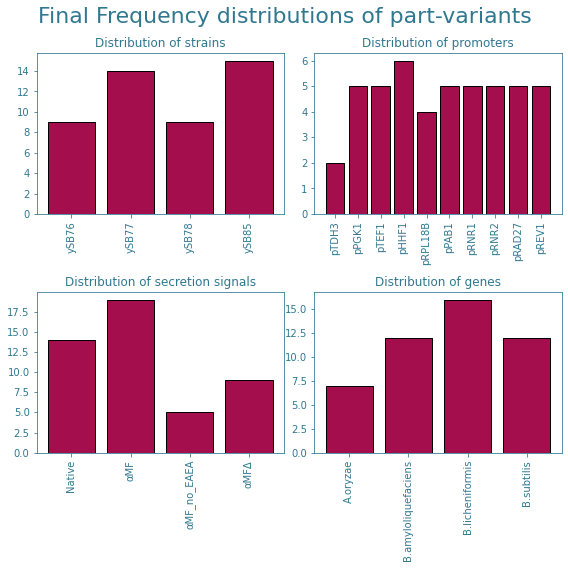

In [17]:

# Plotting the occurances of each part withing the selected constructs

fig, axs = plt.subplots(2,2, figsize=(8,8))
axs[0][0].hist(named_samples["str_idx"], align='mid', bins=np.append(indeces_strains,5)-0.5, 
               color='#a40e4c', edgecolor = 'black', rwidth=0.8)
axs[0][0].patch.set_alpha(0.0)
axs[0][0].set_xticks(indeces_strains)
axs[0][0].set_xticklabels(list(part_names.Name[indeces_strains]), rotation = 90)
axs[0][0].set_title('Distribution of strains')
axs[0][1].hist(named_samples["pro_idx"], align='mid', bins=np.append(indeces_promoters,15)-0.5,
               color='#a40e4c', edgecolor = 'black', rwidth=0.8)
axs[0][1].patch.set_alpha(0.0)
axs[0][1].set_xticks(indeces_promoters)
axs[0][1].set_xticklabels(list(part_names.Name[indeces_promoters]), rotation = 90)
axs[0][1].set_title('Distribution of promoters')
axs[1][0].hist(named_samples["sec_idx"], align='mid', bins=np.append(indeces_secretion,19)-0.5,
               color='#a40e4c', edgecolor = 'black', rwidth=0.8)
axs[1][0].patch.set_alpha(0.0)
axs[1][0].set_xticks(indeces_secretion)
axs[1][0].set_xticklabels(list(part_names.Name[indeces_secretion]), rotation = 90)
axs[1][0].set_title('Distribution of secretion signals')
axs[1][1].hist(named_samples["gen_idx"], align='mid', bins=np.append(indeces_genes,23)-0.5,
               color='#a40e4c', edgecolor = 'black', rwidth=0.8)
axs[1][1].patch.set_alpha(0.0)
axs[1][1].set_xticks(indeces_genes)
axs[1][1].set_xticklabels(list(part_names.Name[indeces_genes]), rotation = 90)
axs[1][1].set_title('Distribution of genes')

fig.suptitle('Final Frequency distributions of part-variants', fontsize=22)
fig.tight_layout()
fig.savefig('./figures/freq_dist_updated.pdf', transparent=True)
fig.savefig('./figures/freq_dist_updated.png', transparent=True)

## (Optional) Step 4: Validating of each part-variant contributes sufficiently to the overall variance within the subset.

This part is becoming a bit more complex, so do not worry if are having difficulties following what is going on. Just take it slow and do some additional googling when needed. Especially the theory behind Principle Component Analysis (PCA) is rather complex and difficult to explain in just a few short sentences. There are however plenty of educational materials available online. If interested, [Jonathon Shlens](https://arxiv.org/pdf/1404.1100.pdf) wrote a nice (but still complicated) tutorial. For a more intuitive explanation, we highly recommend watching [this video](https://www.youtube.com/watch?v=_UVHneBUBW0) on how PCA can be used in genetics. 

If you've read the video linked above, you should by now know that PCA can be used to capture the variance within a dataset into a set of principle components. It also discussed how much each 'cell' contributes to each principle component. In our case however, the interest lies within how much each part-variant contributes to the total variance within the dataset. Ideally, this should be equal for all variants of a part. 

This can be determined by first figuring out how much each part-variant contributes (i.e. the weight) to each principle component. One way of achieving this is by dividing the loading of each part-variant by the sum of all absolute loadings in the eigenarray ($\vec{l}$) of the principle component. In order to get the weight vector ($\vec{w}$) of principle component $i$ ($PCi$), the following formula is used:

$$ \vec{w}_{PCi}=\frac{\vec{l}_{PCi}}{\sum(abs(\vec{l}_{PCi}))}$$

The weight vectors of all principle components are combined into a single weight matrix $\mathbf{W}$. The dot product between this matrix and the explained variance ratio vector of the PCA ($\vec{var_{PC}}$), creates a vector in which each element represents how much each part-variant contributed to the total variance within the dataset ($\vec{var_{part}}$):

$$ \vec{var_{part}}=\mathbf{W}\cdot\vec{var_{PC}}$$

All that is left to do now, is group all part-variants according to the part they belong and analise if there are any major differences within each part!

Now that the theory is explained, it is time to discuss the implementation

In order to be able to apply PCA to the subset, each part-variant needs its own dimension. A simple trick often used in ML is to one-hot-encode the data

In [10]:
samples_art_oneh = pd.get_dummies(data=named_samples.drop('Line Name', axis=1), columns=['str_idx', 'pro_idx', 'sec_idx', 'gen_idx'])
samples_art_oneh.head()

,str_idx_1,str_idx_2,str_idx_3,str_idx_4,pro_idx_5,pro_idx_6,pro_idx_7,pro_idx_8,pro_idx_9,pro_idx_10,...,pro_idx_13,pro_idx_14,sec_idx_15,sec_idx_16,sec_idx_17,sec_idx_18,gen_idx_19,gen_idx_20,gen_idx_21,gen_idx_22
0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


PCA is generally used to reduce the number of dimensions of the data at a minimal loss of variability within the data. If you however wish to keep all variance, you can set the number of principle components to the total number of dimensions in your data. It should be noted that the final few principle components generally do not add a substantial amount of variance. In order to save computational resources, you could decide to skip the final few principle components.

In [11]:

# Select the number of principal components you with to analyse. Set to 4+10+4+4=22 to include all variability
number_of_PCA_components = len(samples_art_oneh.columns)

print(number_of_PCA_components)

22


In [12]:
# Starting the Principal Componant Analysis in order to determine wether each part adds sufficient variablity 
# to the set of selected constructs


pca_constructs = PCA(n_components=number_of_PCA_components)
principalComponents_constructs = pca_constructs.fit_transform(samples_art_oneh) 

print(f"sum of all components: {np.sum(pca_constructs.explained_variance_ratio_)}") # A measure of how much variability is included in the PCA. If 1.0, all variability is included
print(pca_constructs.explained_variance_ratio_) # Shows how much each PC contributes to the total amount of variability

eigenarray = pca_constructs.components_ # Extracts the influence of each variable on each principle component

contributions_pca = (abs(eigenarray)*100) / abs(eigenarray).sum(axis=1, keepdims=True) # Expresses the contribution of each variable to a PC in percentages

#print(contributions_pca)
contributions_pca = pd.DataFrame(contributions_pca, columns = samples_art_oneh.columns)
print(np.sum(contributions_pca.iloc[0])) # Shows that the sum of the influence of each variable on the first PC is equal to 100% 
print(contributions_pca.iloc[0]) # Shows the relative influence of each variable on the first PC

sum of all components: 1.0
[1.34215454e-01 1.18680097e-01 1.05144805e-01 9.58773015e-02
 8.49547649e-02 7.84134911e-02 5.81035490e-02 5.01599320e-02
 4.73217074e-02 3.84511821e-02 3.26216081e-02 3.00403124e-02
 2.70467714e-02 2.53019092e-02 2.43909413e-02 2.04821530e-02
 1.51948769e-02 1.35991433e-02 1.10340200e-32 6.64412756e-33
 2.01438854e-33 2.57505802e-34]
99.99999999999999
str_idx_1      5.265150
str_idx_2      8.330218
str_idx_3      0.949433
str_idx_4     12.645935
pro_idx_5      1.403962
pro_idx_6      1.235543
pro_idx_7      1.914011
pro_idx_8      1.940550
pro_idx_9      0.789976
pro_idx_10     3.130240
pro_idx_11     4.789054
pro_idx_12     1.958768
pro_idx_13     1.192852
pro_idx_14     0.038958
sec_idx_15     8.431943
sec_idx_16    14.113263
sec_idx_17     1.381231
sec_idx_18     4.300089
gen_idx_19    10.642439
gen_idx_20     2.235131
gen_idx_21    10.859281
gen_idx_22     2.451973
Name: 0, dtype: float64


In [13]:
# Obtain the percentage of variance originating from each variable by calculating the dot product between: 
# - the explained variance ratio of each PC 
# - how much each variable contributed to that PC

perc_var_per_parameter = np.dot(pca_constructs.explained_variance_ratio_, contributions_pca)


print(perc_var_per_parameter) # How much each variable contributed to the total variance in percentages
       
print(np.sum(perc_var_per_parameter)) # The sum of all percentages. Should be 100% if number_of_PCA_components=22

[5.14144676 6.10065601 4.57337369 6.25052728 2.92133983 3.46559123
 3.67369354 3.6298389  3.85669364 3.47936611 4.75098699 3.1285419
 2.7906857  3.16425484 5.53392297 6.28249794 4.36693138 5.36725083
 5.22178855 5.31417268 5.83498721 5.15145201]
99.99999999999999


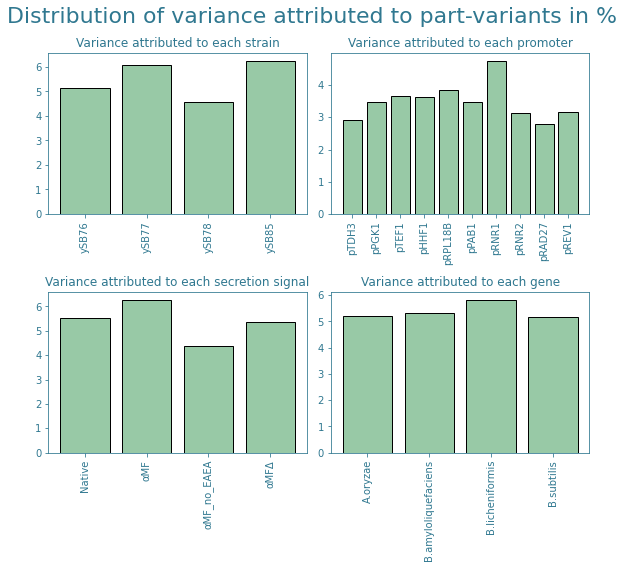

In [14]:
# Creating a bar plot of contribution of each variable to the total variance in perentages
fig, axs = plt.subplots(2,2, figsize=(8,8))
axs[0][0].bar(indeces_strains, perc_var_per_parameter[indeces_strains-1], edgecolor = 'black', color='#98c9a6')
axs[0][0].set_xticks(indeces_strains)
axs[0][0].set_xticklabels(list(part_names.Name[indeces_strains]), rotation = 90)
axs[0][0].set_title('Variance attributed to each strain')
axs[0][1].bar(indeces_promoters, perc_var_per_parameter[indeces_promoters-1], edgecolor = 'black', color='#98c9a6')
axs[0][1].set_xticks(indeces_promoters)
axs[0][1].set_xticklabels(list(part_names.Name[indeces_promoters]), rotation = 90)
axs[0][1].set_title('Variance attributed to each promoter')
axs[1][0].bar(indeces_secretion, perc_var_per_parameter[indeces_secretion-1], edgecolor = 'black', color='#98c9a6')
axs[1][0].set_xticks(indeces_secretion)
axs[1][0].set_xticklabels(list(part_names.Name[indeces_secretion]), rotation = 90)
axs[1][0].set_title('Variance attributed to each secretion signal')
axs[1][1].bar(indeces_genes, perc_var_per_parameter[indeces_genes-1], edgecolor = 'black', color='#98c9a6')
axs[1][1].set_xticks(indeces_genes)
axs[1][1].set_xticklabels(list(part_names.Name[indeces_genes]), rotation = 90)
axs[1][1].set_title('Variance attributed to each gene')

fig.suptitle('Distribution of variance attributed to part-variants in %', fontsize=22)
fig.tight_layout()
fig.savefig('./figures/var_dist.pdf', transparent=True)
fig.savefig('./figures/var_dist.png', transparent=True)

## (optional) Step 5: Excluding some samples

This step is only relevant once the final list of samples has been constructed and the physical experiments have already started. It is for instance possible that some samples cannot be included in the analysis due to a lack of measuring materials or accidents in the lab. If this happens too often for samples with for instance one specific secretion peptide, this secretion peptide might become under respesented in the subset used for further analysis. It might therefore be wise to check how much effort needs to be spend on either saving the sample or redoing the experiments for this sample. 

By running the cells below, the lost samples can be excluded from the subset. The effect of this exclusion can be seen by re-running the cells starting at step 3. If it turns out that removing these samples has close to no effect on the variance within the dataset, these samples can be skipped safely. If it turns out that the removal the samples causes one part-variant to be under-represented, it might be wise to put additional effort into including some of the removed samples.

In [15]:

dropped_samples = ["#03", "#04", "#07", "#17", "#36", "#40", "#43", "#48", "#57", "#64", "#21", "#06", "#11","#20", "#32", "#42", "#59"]
mask = named_samples['Line Name'].isin(dropped_samples)

print(named_samples)
named_samples = named_samples[~mask]
print(named_samples)

    str_idx  pro_idx  sec_idx  gen_idx Line Name
0         2        6       16       22       #01
1         4       11       18       19       #02
2         1        5       16       19       #03
3         1       11       18       19       #04
4         3        8       16       22       #05
..      ...      ...      ...      ...       ...
59        4       14       15       22       #60
60        4       14       17       20       #61
61        4       13       16       20       #62
62        1       12       16       21       #63
63        4        6       18       19       #64

[64 rows x 5 columns]
    str_idx  pro_idx  sec_idx  gen_idx Line Name
0         2        6       16       22       #01
1         4       11       18       19       #02
4         3        8       16       22       #05
7         3        8       15       22       #08
8         4       11       15       22       #09
9         2        8       16       22       #10
11        3       11       15       19       #

In [16]:
print(len(named_samples["str_idx"]))

47
